In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import cca.cca
import cca.synth_data
import cca.kron_pca

#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def disp_cov(cov, title=None):
    plt.imshow(cov, vmin=-3, vmax=3, cmap="RdGy")
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.show()

(500, 10) 51.44184880377579 51.44185565288134
100


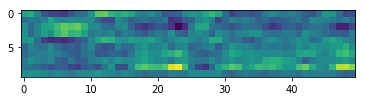

In [3]:
K = cca.synth_data.gen_gp_kernel("squared_exp", spatial_scale=5., temporal_scale=2.)
d = 10
N = 10
T = 100
T_pi = 5
num_to_concat = 5

noise_dim = 1e-10  #1e10
noise_variance = 1
noise_spectrum = noise_variance*np.exp(-np.arange(N)/(noise_dim/2))
noise_V = scipy.stats.ortho_group.rvs(N)
noise_cov = np.dot(noise_V, np.dot(np.diag(noise_spectrum), noise_V.T))

X, E, full_pi, embedding_pi, noisy_cross_covs = cca.synth_data.embed_gp(T, N, d, K, noise_cov, T_pi, num_to_concat=num_to_concat)

print(X.shape, full_pi, embedding_pi)
print(N*T_pi*2)
plt.imshow(X[:5*X.shape[1], :].T)
plt.show()

491
Here
9.544959777646154e-11
CV eigvall < 0: -0.22136552101438633
CV eigvall < 0: -0.24985627106083141
CV eigvall < 0: -0.2499407461928038
CV eigvall < 0: -0.028753735282976114
CV eigvall < 0: -0.028705210032347613
CV eigvall < 0: -0.009373612057329051
CV eigvall < 0: -0.009380454947572121
CV eigvall < 0: -0.0029217867501856233
CV eigvall < 0: -0.002934992511726037
CV eigvall < 0: -0.2585472351549124
CV eigvall < 0: -0.25863265914170064
CV eigvall < 0: -0.23164171584491353
CV eigvall < 0: -0.016800036372902352
CV eigvall < 0: -0.0172928397536451
CV eigvall < 0: -0.014662028526679407
CV eigvall < 0: -0.014970501464432672
CV eigvall < 0: -0.006744984642450929
CV eigvall < 0: -0.006702330287656541
CV eigvall < 0: -0.27808263226589813
CV eigvall < 0: -0.27822956185025943
CV eigvall < 0: -0.2782280771305877
CV eigvall < 0: -0.27641485316289405
CV eigvall < 0: -0.01650423417007332
CV eigvall < 0: -0.003244017967429304
CV eigvall < 0: -0.004402431958099355
CV eigvall < 0: -0.004405951261170

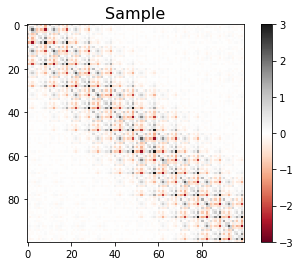

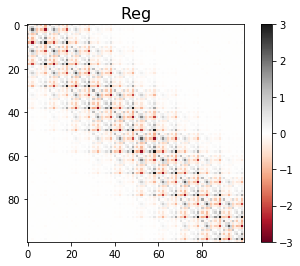

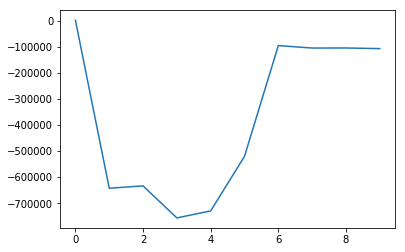

In [4]:
skip = 1 #T_pi
n = int(np.floor((len(X) - T_pi*2)/skip) + 1) #is this right?
print(n)
X_with_lags = np.zeros((n, N*T_pi*2))
for i in range(n):
    X_with_lags[i, :] = X[i*skip : i*skip + T_pi*2, :].ravel()
X_with_lags -= X_with_lags.mean(axis=0)

X_ctd = X_with_lags - X_with_lags.mean(axis=0)
cov_sample = np.dot(X_ctd.T, X_ctd)/len(X_ctd)
ll, cov_reg = cca.kron_pca.cv_toeplitz(X_with_lags, N, T_pi*2)

print(np.max(cov_sample))

disp_cov(cov_sample, "Sample")
disp_cov(cov_reg, "Reg")

plt.plot(ll.mean(axis=0))
plt.show()

In [2]:
from imp import reload
reload(cca.optimize)

reg = "kron"
skip = 1 #T_pi
num_folds = 10
reg_ops = {'skip': skip, 'num_folds': num_folds}

no_reg = cca.optimize.ComplexityComponentsAnalysis(T=T_pi, device=None).estimate_cross_covariance(X)
#no_reg.cross_covs = noisy_cross_covs
reg = cca.optimize.ComplexityComponentsAnalysis(T=T_pi, device=None).estimate_cross_covariance(X, regularization=reg, reg_ops=reg_ops)

pi_proj_reg_vals = np.zeros(N+1)
pi_proj_no_reg_vals = np.zeros(N+1)

for opt_dim in range(1, N+1):    
    reg.fit_projection(X, d=opt_dim)
    no_reg.fit_projection(X, d=opt_dim)
    
    pi_proj_reg = reg.score()
    pi_proj_no_reg = no_reg.score()
    
    pi_proj_reg_vals[opt_dim] = pi_proj_reg
    pi_proj_no_reg_vals[opt_dim] = pi_proj_no_reg
    
    print(opt_dim, pi_proj_no_reg, pi_proj_reg)

NameError: name 'cca' is not defined

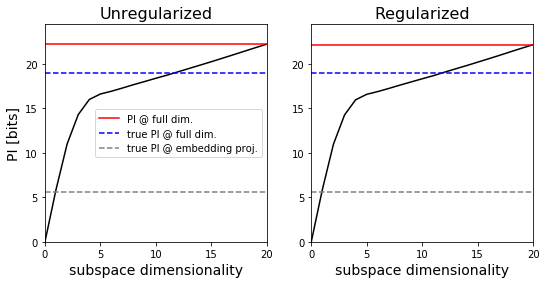

In [51]:
full_pi_reg = np.max(pi_proj_reg_vals)
#embedding_pi_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_reg, proj=E)

full_pi_no_reg = np.max(pi_proj_no_reg_vals)
#embedding_pi_no_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_no_reg, proj=E)

fig, axes = plt.subplots(1, 2, figsize=(8.75, 4))
ax1, ax2 = axes

ax1.plot(np.arange(N+1), pi_proj_no_reg_vals, c="black")
ax1.axhline(full_pi_no_reg, label="PI @ full dim.", c="red")
#ax1.axhline(embedding_pi_no_reg, label="PI @ embedding proj.", c="gray")
#ax1.axvline(d, label="true latent dim.", c="blue")

ax1.set_title("Unregularized", fontsize=16)
ax1.set_xlabel("subspace dimensionality", fontsize=14)
ax1.set_ylabel("PI [bits]", fontsize=14)

ax2.plot(np.arange(N+1), pi_proj_reg_vals, c="black")
ax2.axhline(full_pi_reg, label="PI @ full dim.", c="red")

#ax2.axhline(embedding_pi_reg, label="PI @ embedding proj.", c="gray")
#ax2.axvline(d, label="true latent dim.", c="blue")

ax1.axhline(full_pi, label="true PI @ full dim.", c="blue", linestyle="--")
ax1.axhline(embedding_pi, label="true PI @ embedding proj.", c="gray", linestyle="--")
ax2.axhline(full_pi, label="true PI @ full dim.", c="blue", linestyle="--")
ax2.axhline(embedding_pi, label="true PI @ embedding proj.", c="gray", linestyle="--")

ax2.set_title("Regularized", fontsize=16)
ax2.set_xlabel("subspace dimensionality", fontsize=14)
#ax2.set_ylabel("PI [bits]", fontsize=14)

ax1.legend()

y_max = np.max(np.concatenate((pi_proj_no_reg_vals, pi_proj_reg_vals)))*1.1

ax1.set_xlim([0, N])
ax1.set_ylim([0, y_max])

ax2.set_xlim([0, N])
ax2.set_ylim([0, y_max])

#plt.savefig("figs/N_10_d_3_Nsamps_5000_1xnoise_5dim.pdf", bbox_inches="tight")

plt.show()

0.009748940462959781


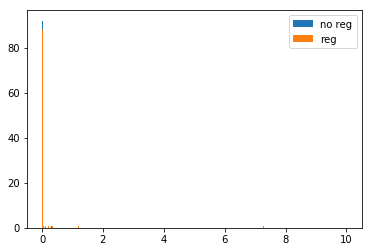

In [26]:
cov_reg = cca.calc_cov_from_cross_cov_mats(cross_cov_mats_reg)
w_reg, _ = np.linalg.eigh(cov_reg)

cov_no_reg = cca.calc_cov_from_cross_cov_mats(cross_cov_mats_no_reg)
w_no_reg, _ = np.linalg.eigh(cov_no_reg)

plt.hist(w_no_reg, bins=500, range=(0, 10), label="no reg")
plt.hist(w_reg, bins=500, range=(0, 10), label="reg")
plt.legend()

print(np.min(w_no_reg))

In [56]:
def stationarize(cov):
    cross_cov_mats = cca.calc_cross_cov_mats_from_cov(10, 5*2, cov)
    cov_stationary = cca.calc_cov_from_cross_cov_mats(cross_cov_mats)
    return cov_stationary

def psdize(cov):
    w, V = np.linalg.eigh(cov)
    w, V = w[::-1], V[:, ::-1]
    w = w - np.min(w) + 100
    cov_psd = np.dot(V, np.dot(np.diag(w), V.T))
    return cov_psd

def min_eig(cov):
    w, _ = np.linalg.eigh(cov)
    return np.min(w)
    
cov = np.copy(cov_no_reg)

In [57]:
#cov = psdize(cov)
print("eig:", min_eig(cov))

cov = stationarize(cov)

print("eig:", min_eig(cov))

cov = psdize(cov)

print("eig:", min_eig(cov))
print(np.max(np.abs(cov[10:20, 0:10] - cov[20:30, 10:20])))

cov = stationarize(cov)

print("eig:", min_eig(cov))
print(np.max(np.abs(cov[10:20, 0:10] - cov[20:30, 10:20])))


eig: -0.0004508111543175309
eig: -0.00045081115431683136
eig: 99.99999999999994
5.6288307348495437e-14
eig: 100.0
0.0


In [46]:
print(cov[10:20, 0:10] - cov[20:30, 10:20])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

(499800, 10)


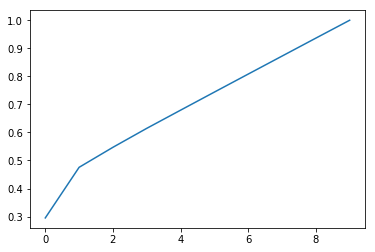

In [36]:
print(X.shape)
X_ctd = X - X.mean(axis=0)
cov = np.dot(X_ctd.T, X_ctd)/len(X_ctd)
w, _ = np.linalg.eigh(cov)
plt.plot(np.cumsum(w[::-1])/np.sum(w))

In [6]:
import torch
import numpy as np

In [8]:
I = torch.eye(10, device=None, dtype=torch.float64)
a = [I]
isinstance(a[0], torch.tensor)

TypeError: isinstance() arg 2 must be a type or tuple of types

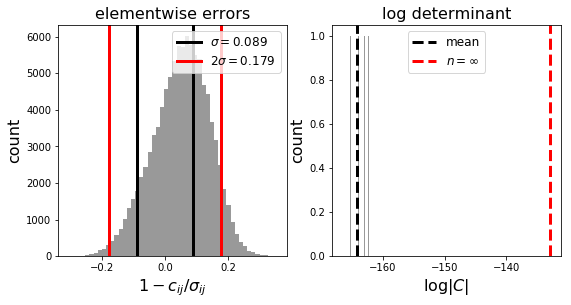

In [216]:
n = 200
p = 100
rho = 0.75

cov = rho*np.ones((p, p)) + (1.-rho)*np.eye(p)

fig, axes = plt.subplots(1, 2, figsize=(9, 4.25))
ax1, ax2 = axes

num_trials = 10
log_det_vals = np.zeros(num_trials)
err_vals = np.zeros((num_trials, p**2))
for i in range(num_trials):
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=cov, size=n)
    cov_sample = np.dot(X.T, X)/n
    _, log_det = np.linalg.slogdet(cov_sample)
    log_det_vals[i] = log_det
    
    err_vals[i, :] = ((cov - cov_sample)/cov).flatten()
    
_, true_log_det = np.linalg.slogdet(cov)
mean_log_det = np.mean(log_det_vals)

ax1.hist(err_vals.flatten(), bins=50, color="0.6")
std = np.std(err_vals)
ax1.axvline(std, label="$\sigma = $" + str(np.round(std, 3)), c="black", linewidth=3, linestyle="-")
ax1.axvline(-std, c="black", linewidth=3, linestyle="-")
ax1.axvline(2*std, label="$2\sigma = $" + str(np.round(2*std, 3)), c="red", linewidth=3, linestyle="-")
ax1.axvline(-2*std, c="red", linewidth=3, linestyle="-")
ax1.legend(fontsize=12,  loc="upper right")
ax1.set_xlabel("$1 - c_{ij} / \sigma_{ij}$", fontsize=16)
ax1.set_ylabel("count", fontsize=16)
ax1.set_title("elementwise errors", fontsize=16)

ax2.hist(log_det_vals, bins=50, color="0.6")
ax2.axvline(mean_log_det, label="mean", c="black", linewidth=3, linestyle="--")
ax2.axvline(true_log_det, label="$n = \infty$", c="red", linewidth=3, linestyle="--")
ax2.legend(fontsize=12, loc="upper center")
ax2.set_xlabel("$\log |C|$", fontsize=16)
ax2.set_ylabel("count", fontsize=16)
ax2.set_title("log determinant", fontsize=16)

plt.savefig("figs/perils_of_covariance.pdf", bbox_inches="tight")

plt.show()


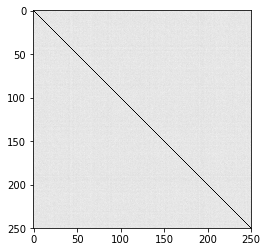

In [201]:
plt.imshow(cov_sample, vmin=0, vmax=1, cmap="gray_r")

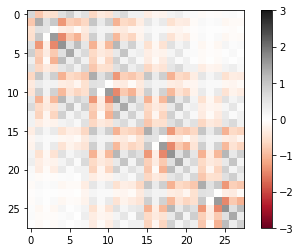

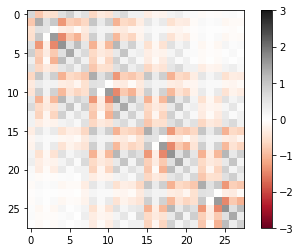

4.6396525352552574e-07


In [20]:
N = N
T = 2*T_pi

def toeplitzify(C, N, T):
    C_toep = np.zeros((N*T, N*T))
    for delta_t in range(T):
        to_avg_lower = np.zeros((T-delta_t, N, N))
        to_avg_upper = np.zeros((T-delta_t, N, N))

        for i in range(T-delta_t):
            to_avg_lower[i, :, :] = C[(delta_t + i)*N : (delta_t + i + 1)*N, i*N : (i + 1)*N]
            to_avg_upper[i, :, :] = C[i*N : (i + 1)*N, (delta_t + i)*N : (delta_t + i + 1)*N]

        block_avg = 0.5*(np.mean(to_avg_lower, axis=0) + np.mean(to_avg_upper, axis=0).T)

        for i in range(T-delta_t):
            C_toep[(delta_t + i)*N : (delta_t + i + 1)*N, i*N : (i + 1)*N] = block_avg
            C_toep[i*N : (i + 1)*N, (delta_t + i)*N : (delta_t + i + 1)*N] = block_avg.T

    return C_toep

C_toep = toeplitzify(cov_sample, N, T)

disp_cov(cov_sample)
disp_cov(C_toep)

w, _ = scipy.linalg.eigh(C_toep)
print(np.min(w))








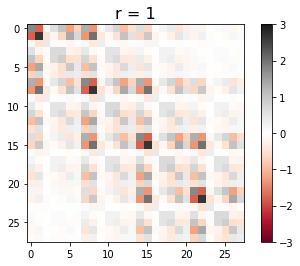

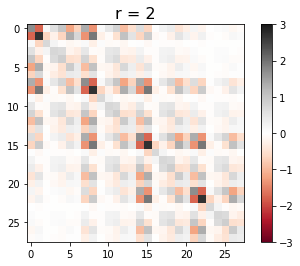

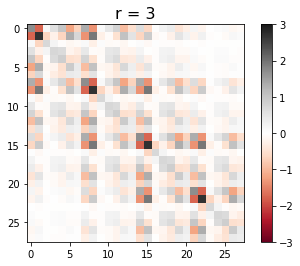

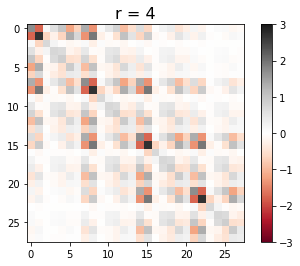

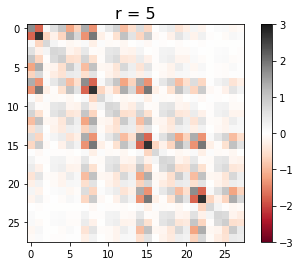

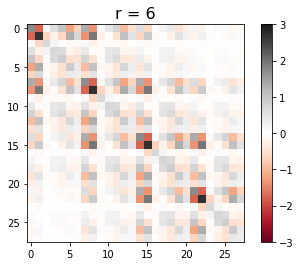

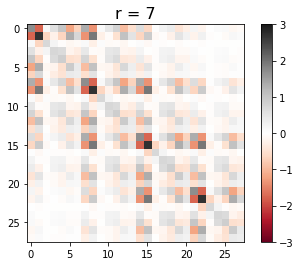

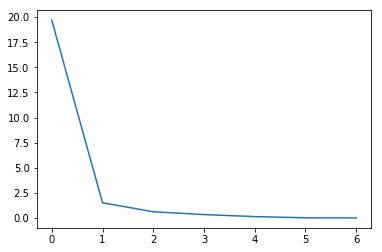

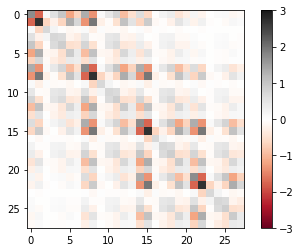

In [15]:
P = cca.kron_pca.build_P(T)
X_ctd = X_with_lags - X_with_lags.mean(axis=0)
cov = np.dot(X_ctd.T, X_ctd)/len(X_with_lags)
R_C = cca.kron_pca.pv_rearrange(cov, N, T)
to_svd = P.dot(R_C)

errs = []
for r in range(1, 2*T):
    U, s, Vt = cca.kron_pca.fast_svd(to_svd, rank=r)
    trunc_svd = U.dot(np.diag(s)).dot(Vt)
    cov_reg = cca.kron_pca.pv_rearrange_inv(P.T.dot(trunc_svd), N, T)
    disp_cov(cov_reg, "r = " + str(r))
    err = np.sum(np.abs(cov - cov_reg))
    errs.append(err)
    
plt.plot(errs)
plt.show()
    
disp_cov(cov_reg)